In [2]:
import copy
import gym
import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from stable_baselines3 import PPO, DDPG
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy

In [5]:
class Swing(gym.Env):
    def __init__(self, target=np.pi / 2, L0=0.8, omega_0=-0.5):
        super(Swing, self).__init__()
        self.observation_space = gym.spaces.Box(
            low=np.array([0, -10]), high=np.array([2 * np.pi, 10])
        )

        self.action_space = gym.spaces.Box(
            low=np.array([-1, -1]), high=np.array([1, 1])
        )
        self.L0 = L0
        self.omega_0 = omega_0
        self.target = target
        self.time = 0
        self.dt = 0.1
        self.pumps = 0
        self.phi = [np.pi / 8]
        self.phi_dot = [self.omega_0]
        self.L = [self.L0]
        self.a_history = []
        self.d_history = []

    def fun(self, t, y, a, d, L0=1, tau=1, g=9.81):
        y0_dot = y[1]
        y1_dot = (
            -(2 * y[1] / y[2]) * ((y[2] - L0) / tau + y[2] * a * np.cos(y[0] + d) / tau)
            - g * np.sin(y[0]) / y[2]
        )
        y2_dot = -(y[2] - L0) / tau + y[2] * a * np.cos(y[0] + d) / tau
        y_dot = np.hstack((y0_dot, y1_dot, y2_dot))
        return y_dot

    def step(self, action):
        a = action[0]
        self.a_history.append(a)
        d = np.pi * action[1]
        self.d_history.append(d)
        sol = si.solve_ivp(
            self.fun,
            [self.time, self.time + self.dt],
            y0=[self.phi[-1], self.phi_dot[-1], self.L[-1]],
            args=(a, d),
        )
        phi = np.mod(sol.y[0][-1], 2 * np.pi)
        self.phi.append(phi)
        phi_dot = sol.y[1][-1]
        self.phi_dot.append(phi_dot)
        L = sol.y[2][-1]
        self.L.append(L)
        state = np.array([phi, phi_dot])
        if np.isclose(state[0], self.target, rtol=0.1):
            reward = 10
            done = True
            # print("Success! :-)")
        elif self.pumps > 50:
            reward = -1
            done = True
        else:
            reward = -1
            done = False
        info = {}
        self.time += self.dt
        self.pumps += 1
        return state, reward, done, info

    def reset(self):
        self.time = 0
        self.pumps = 0
        self.L = [self.L0]
        self.phi = [np.pi / 8]
        self.phi_dot = [self.omega_0]
        state = np.array([self.phi[-1], self.phi_dot[-1]])
        self.a_history.clear()
        self.d_history.clear()
        return state

    def render(self):
        pass

In [ ]:
env = Swing(target=np.pi)
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=2e5)

In [9]:
model.save("fullswingup")

model = PPO.load("fullswingup.zip", env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [10]:
obs = env.reset()
done = False
i = 0
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    env.render()
    i += 1

a_actions = copy.deepcopy(env.a_history)
a_actions.insert(0, 0)

d_actions = copy.deepcopy(env.d_history)
d_actions.insert(0, 0)

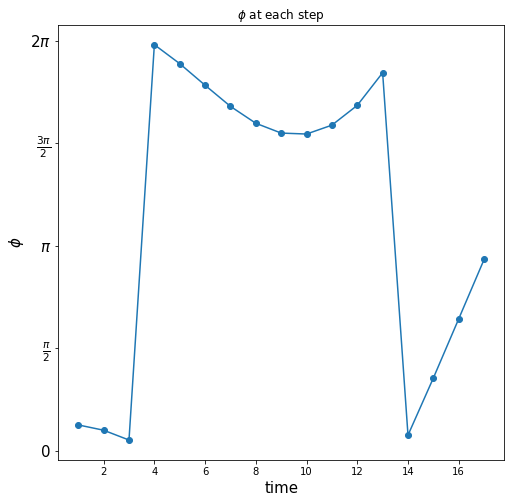

In [11]:
times = np.linspace(1, len(env.phi), len(env.phi))
plt.figure(figsize=(8, 8))
plt.plot(times, env.phi, "-o")
plt.title(r"$\phi$ at each step")
plt.xlabel("time", fontsize=15)
plt.ylabel(r"$\phi$", fontsize=15)
plt.yticks(
    np.linspace(0, 2 * np.pi, 5),
    labels=["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"2$\pi$"],
    fontsize=15,
)
plt.show()

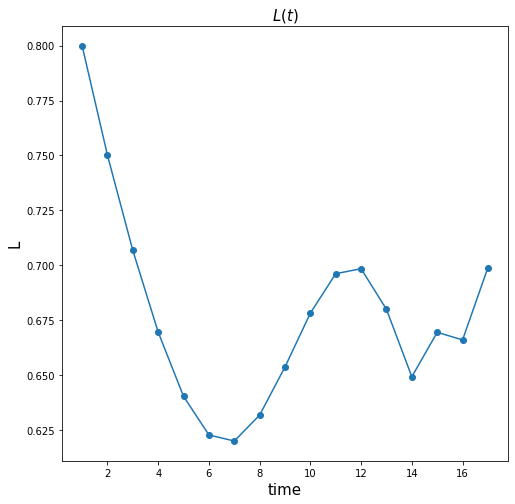

In [12]:
plt.figure(figsize=(8, 8))
plt.plot(times, env.L, "-o")
plt.xlabel("time", fontsize=15)
plt.ylabel(r"L", fontsize=15)
plt.title(r"$L(t)$", fontsize=15)
plt.show()

In [13]:
env.L

[0.8,
 0.7500461998460803,
 0.706679399200773,
 0.669431064286293,
 0.6401916247934457,
 0.6226180051608977,
 0.6198486571358316,
 0.6316851077450376,
 0.6536404845331351,
 0.6781490248164258,
 0.6961020827789003,
 0.6983686980404253,
 0.6798355834470682,
 0.649137344558775,
 0.6693937589088036,
 0.6659282746285164,
 0.6988924218622681]

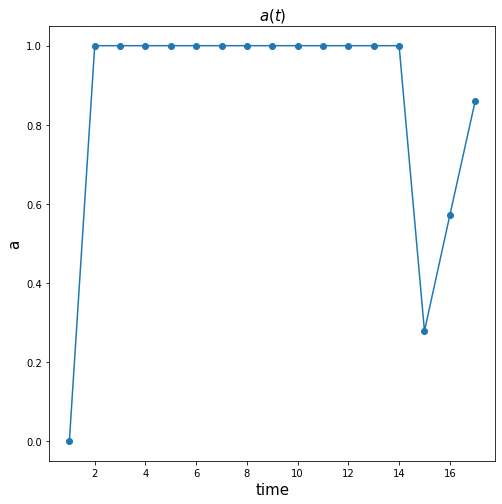

In [14]:
plt.figure(figsize=(8, 8))
plt.plot(times, a_actions, "-o")
plt.xlabel("time", fontsize=15)
plt.ylabel("a", fontsize=15)
plt.title(r"$a(t)$", fontsize=15)
plt.show()

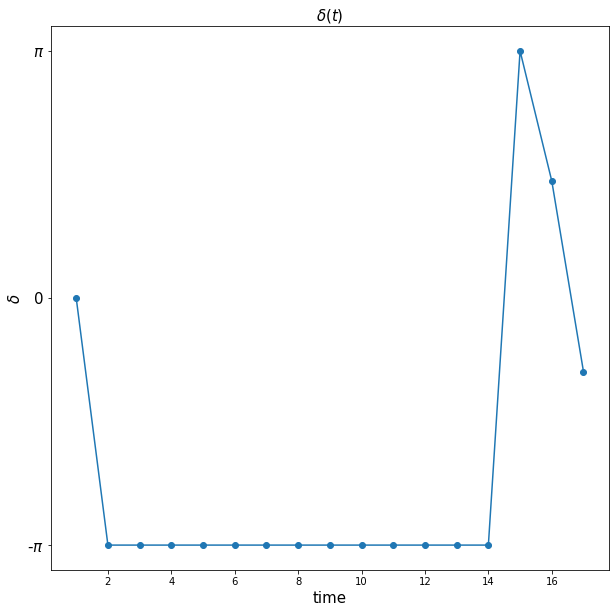

In [15]:
f, ax = plt.subplots(figsize=(10, 10))

ax.plot(times, d_actions, "-o")
# ax.yaxis.set_major_formatter(tck.FormatStrFormatter('$\pi$'))
# ax.yaxis.set_major_locator(tck.MultipleLocator(base=0.5))
# plt.plot(times, d_actions[-23:], "-o")
ax.set_xlabel("time", fontsize=15)
ax.set_ylabel(r"$\delta$", fontsize=15)
ax.set_title(r"$\delta(t)$", fontsize=15)
ax.set_yticks(
    np.linspace(-np.pi, np.pi, 3), labels=[r"-$\pi$", r"0", r"$\pi$"], fontsize=15
)
plt.show()

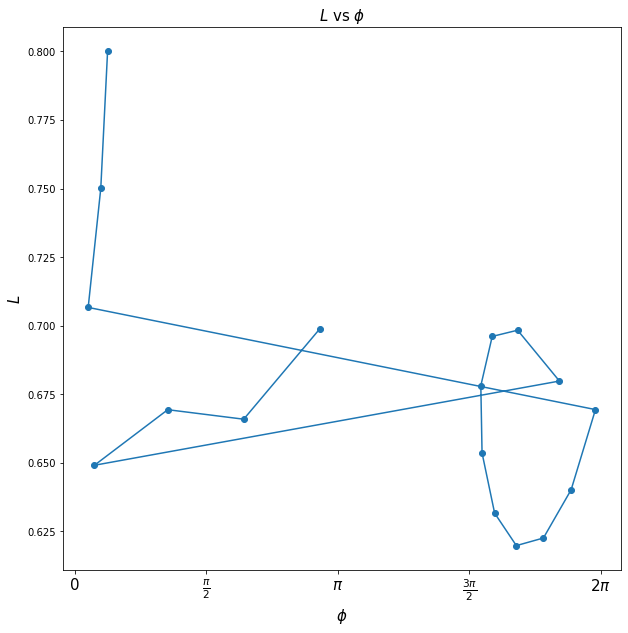

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(env.phi, env.L, "-o")
ax.set_xlabel(r"$\phi$", fontsize=15)
ax.set_ylabel(r"$L$", fontsize=15)
ax.set_title(r"$L$ vs $\phi$", fontsize=15)
ax.set_xticks(
    np.linspace(0, 2 * np.pi, 5),
    labels=["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"2$\pi$"],
    fontsize=15,
)
plt.show()

$$(\phi, \dot{\phi})$$